In [56]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error

from utils.load_data import load_data
from utils.data_splitter import DataSplitter

df = load_data('data/commodity_prices.csv')
df_grouped = pd.read_csv('data/important_feature_groups.csv')

date_dict = {
    'train_start': "2023-06-01", 'train_end': "2025-06-30",
    'valid_start': "2025-07-01", 'valid_end': "2025-07-31",
    'test_start': "2025-08-01", 'test_end': "2025-08-18"
}

thresholds = {
    'train': 100,
    'valid': 10,
    'test': 5
}

splitter = DataSplitter(df, date_dict, thresholds)
train_df, valid_df, test_df = splitter.run()

In [57]:
# Count records per Product-Market pair
pair_counts = (
    train_df
    .groupby(['Product_Type', 'Market'])
    .size()
    .reset_index(name='Record_Count')
)

# Merge with grouped stats (df_grouped)
merged = (
    pair_counts
    .merge(df_grouped, on=['Product_Type', 'Market'], how='left')
)

# Sort by record count (descending) and seasonal effect size (descending)
merged_sorted = (
    merged
    .sort_values(by=['Mean_Season_Effect_Size', 'Record_Count'], ascending=[False, False])
    .reset_index(drop=True)
)

merged_sorted.head()

,Product_Type,Market,Record_Count,important_features,Mean_Commodity_Effect_Size,Mean_Variety_Type_Effect_Size,Mean_Season_Effect_Size,Mean_Market_Effect_Size,Mean_Year_Effect_Size,Total_Records
0,Papaya|Other|Large,Mazhuvannur VFPCK,523,Season|Market|Year,0.039104,0.000000,0.544504,0.177046,0.413011,550.0
1,Orange|Other|Large,Piravam,117,Season,0.000000,0.000000,0.534722,0.000000,0.000000,149.0
2,Onion|Onion|FAQ,Perumbavoor,621,Commodity|Season|Year,0.203802,0.000000,0.439061,0.000000,0.092896,661.0
3,Mango|Other|Large,Piravam,149,Season|Year,0.018415,0.018415,0.431203,0.000000,0.053818,181.0
4,Drumstick|Drumstick|FAQ,Perumbavoor,611,Season,0.001346,0.000000,0.429083,0.025719,0.026158,651.0


Onion in Perumbavoor

In [59]:
pair_val_df = valid_df[(valid_df['Product_Type'] == 'Onion|Onion|FAQ') & (valid_df['Market'] == 'Perumbavoor')]
pair_val_df.shape  

(26, 9)

In [60]:
pair_test_df = test_df[(test_df['Product_Type'] == 'Onion|Onion|FAQ') & (test_df['Market'] == 'Perumbavoor')]
pair_test_df.shape  

(14, 9)

In [37]:
pair_df = train_df[(train_df['Product_Type'] == 'Onion|Onion|FAQ') & (train_df['Market'] == 'Perumbavoor')]
series = pair_df.set_index('Arrival_Date')['log_Modal_Price'].asfreq('D')
series.head()

Arrival_Date
2023-06-01    7.496097
2023-06-02    7.496097
2023-06-03    7.496097
2023-06-04         NaN
2023-06-05    7.496097
Freq: D, Name: log_Modal_Price, dtype: float64

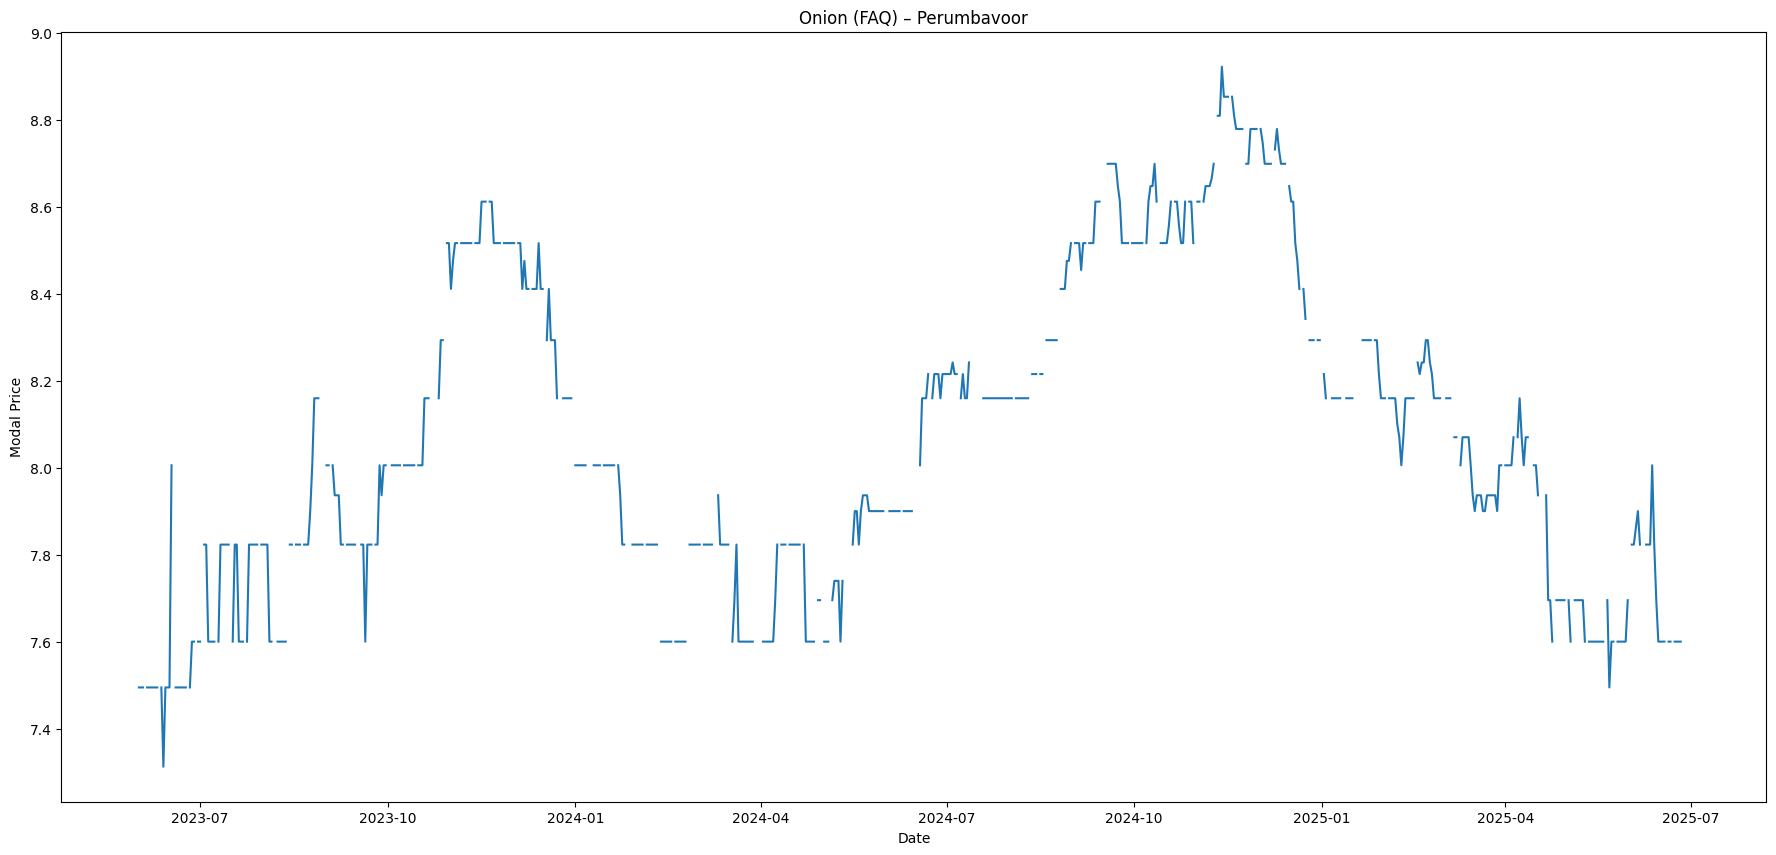

In [38]:
plt.figure(figsize=(22,10))
plt.plot(series)
plt.title("Onion (FAQ) – Perumbavoor")
plt.ylabel("Modal Price")
plt.xlabel("Date")
plt.show()

In [39]:
series_filled = series.ffill(limit=3).interpolate(method='linear')

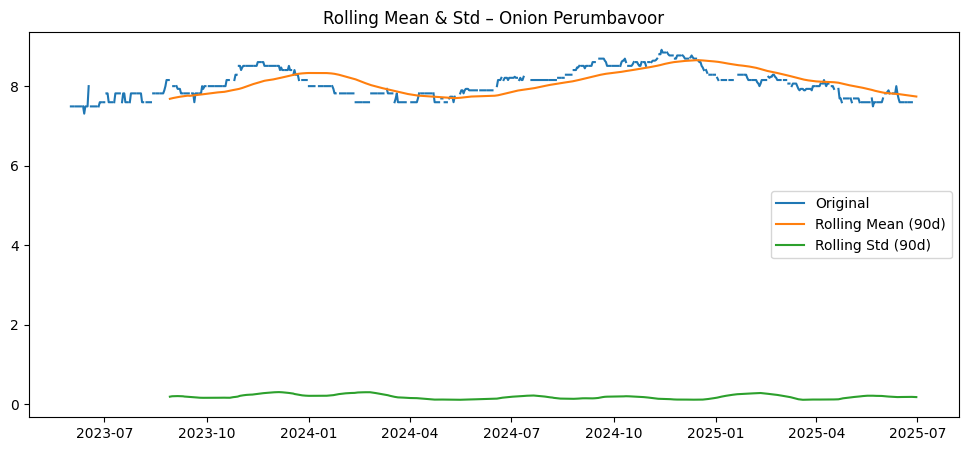

In [52]:
roll_mean = series_filled.rolling(90).mean()
roll_std = series_filled.rolling(90).std()

plt.figure(figsize=(12,5))
plt.plot(series, label="Original")
plt.plot(roll_mean, label="Rolling Mean (90d)")
plt.plot(roll_std, label="Rolling Std (90d)")
plt.legend()
plt.title("Rolling Mean & Std – Onion Perumbavoor")
plt.show()

In [62]:
def adf_test(series):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f"ADF Statistic: {result[0]:.4f}, p-value: {result[1]:.4f}")

def kpss_test(series):
    result = kpss(series.dropna(), regression='c', nlags="auto")
    print(f"KPSS Statistic: {result[0]:.4f}, p-value: {result[1]:.4f}")

print("Original series:")
adf_test(series_filled)
kpss_test(series_filled)

Original series:
ADF Statistic: -1.6149, p-value: 0.4754
KPSS Statistic: 0.6396, p-value: 0.0190


In [ ]:
diff1 = series_filled.diff().dropna()
print("Series with tren removed for 1 lag")
adf_test(diff1)
kpss_test(diff1)

Series with tren removed for 1 lag
ADF Statistic: -6.9745, p-value: 0.0000
KPSS Statistic: 0.2154, p-value: 0.1000


/var/folders/x4/b7s9rw593ls2crh0j05hx9qr0000gn/T/ipykernel_44475/462064618.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags="auto")


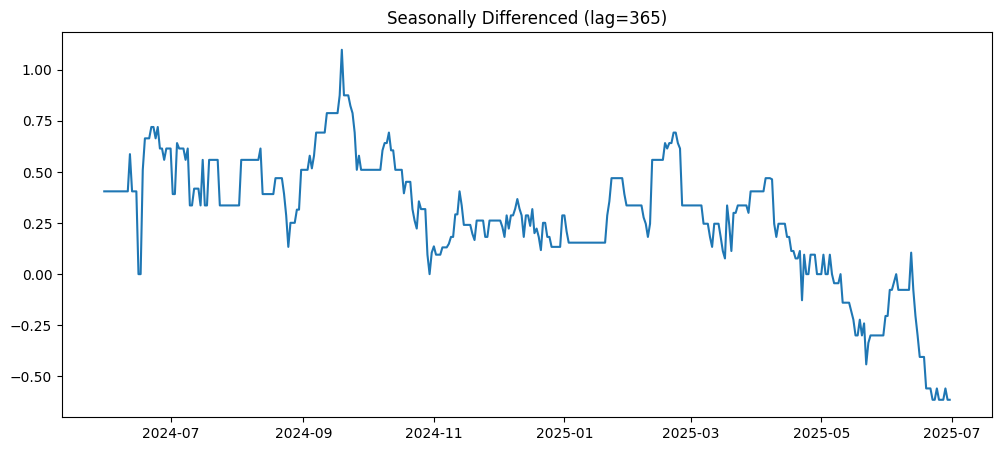

In [45]:
y_seasonal_diff = series_filled - series_filled.shift(365)
plt.figure(figsize=(12,5))
plt.plot(y_seasonal_diff)
plt.title("Seasonally Differenced (lag=365)")
plt.show()

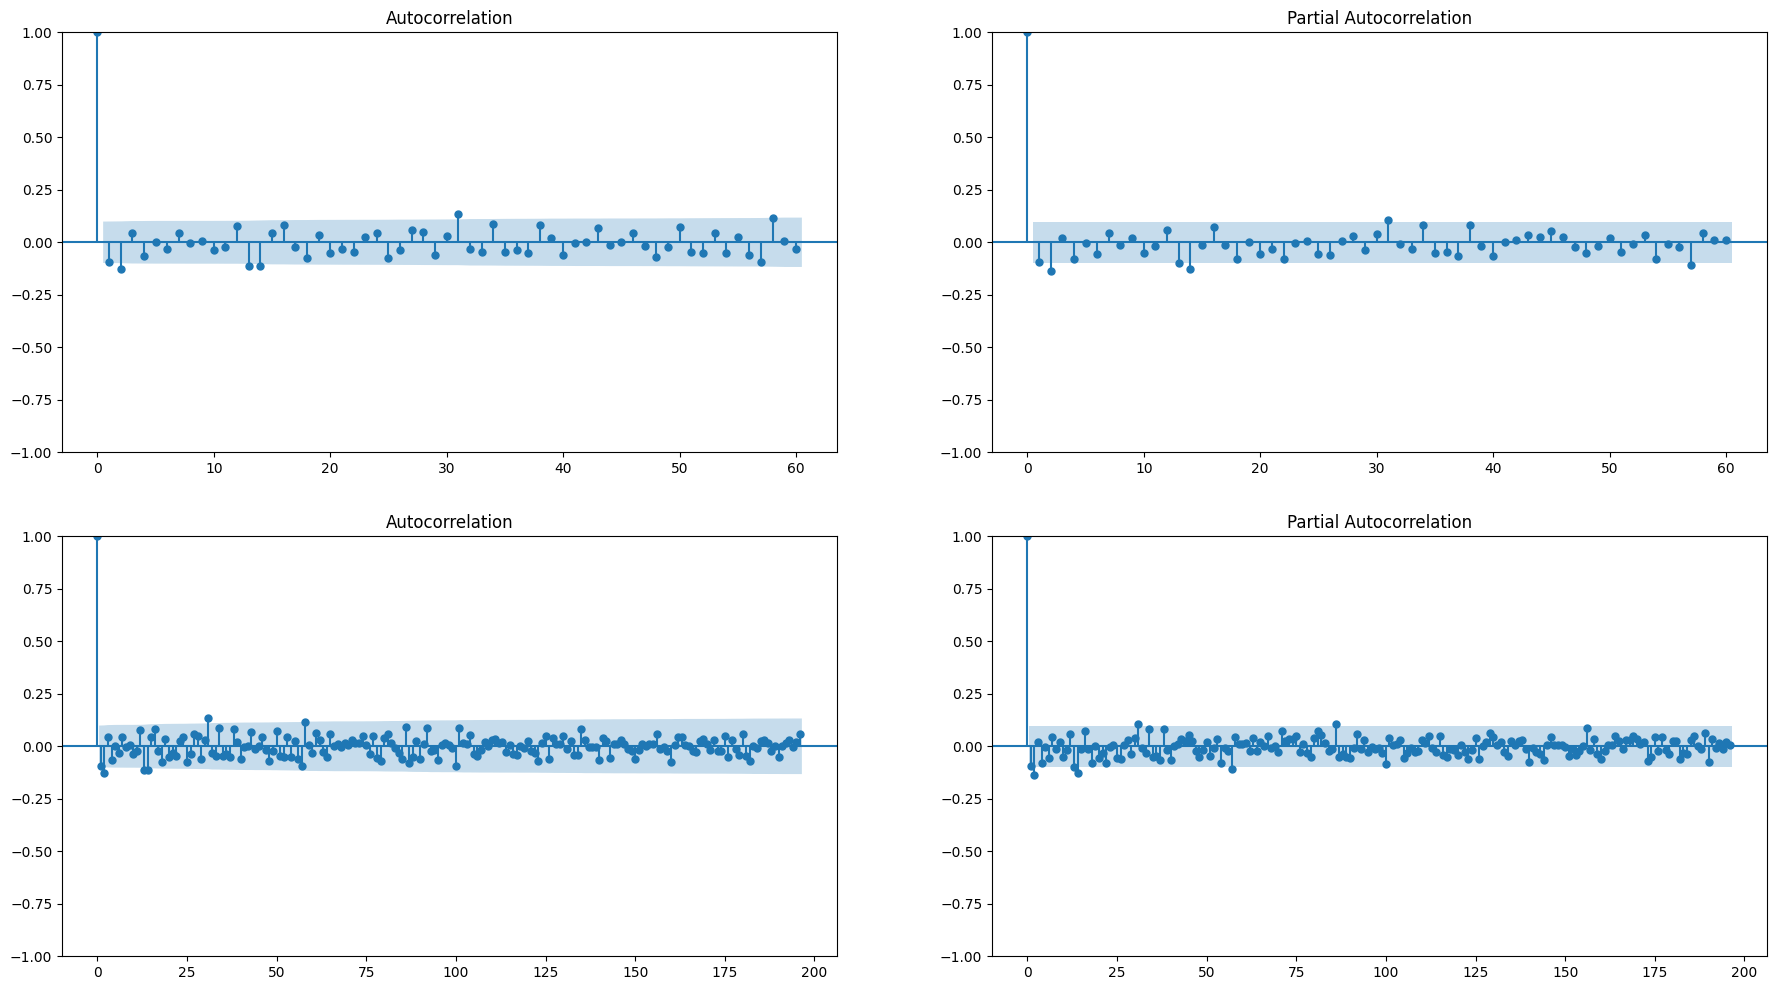

In [ ]:
# After seasonal + first diff
y_diff = y_seasonal_diff.diff().dropna()
nlags_short = min(60, len(y_diff)//2 - 1)    # short-run patterns (days to 2 months)
nlags_long  = min(365, len(y_diff)//2 - 1) 
fig, axes = plt.subplots(2, 2, figsize=(22, 12))
axes = axes.flatten()

plot_acf(y_diff, lags=nlags_short, ax=axes[0])
plot_pacf(y_diff, lags=nlags_short, ax=axes[1])
plot_acf(y_diff, lags=nlags_long, ax=axes[2])
plot_pacf(y_diff, lags=nlags_long, ax=axes[3])

plt.show()

We selected SARIMA(1,1,1)(0,1,0)[365] because the series showed non-stationarity (ADF/KPSS), requiring one non-seasonal difference (d=1), and a clear yearly cycle, handled by seasonal differencing (D=1, s=365). After differencing, PACF had a significant lag-1 spike (suggesting p=1) while ACF had a significant lag-1 spike (suggesting q=1). There were no strong isolated spikes at the seasonal lag (365) in ACF/PACF to justify additional seasonal AR/MA terms beyond seasonal differencing. We therefore start with the parsimonious SARIMA(1,1,1)(0,1,0)[365]

	•	d = 1 — ADF and KPSS tests (and rolling mean) show the series is non-stationary (trend present). Regular differencing once is required to remove trend.
	•	D = 1, s = 365 — Clear yearly pattern in the raw plot and seasonally-differenced plot; seasonal differencing by 365 days flattens the yearly cycle.
	•	p = 1 — PACF after differencing showed a significant spike at lag 1 (direct short-term dependence on yesterday). That suggests a non-seasonal AR(1) component.
	•	q = 1 — ACF after differencing showed a significant spike at lag 1 (short-lived shock pattern). That suggests a non-seasonal MA(1) component.
	•	P = 0, Q = 0 — The ACF/PACF at seasonal lag 365 did not show a clear, isolated significant spike outside the band to demand seasonal AR or MA terms beyond the seasonal differencing already applied; start simpler and add if diagnostics indicate.